# Which one is a better plan?

You work as an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

You are going to carry out a preliminary analysis of the plans based on a relatively small client selection. You'll have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Your job is to analyze the clients' behavior and determine which prepaid plan brings in more revenue.

## Initialization

The Purpose of this project is to analyze data from the telecom operator Megaline. The commercial departement wants to know which of the offered plans brings in the most revenue. There are a number of data frames to work with that include customer use of the service and how its billed. The plan is to clean up the data and perform analysis to discover which plan generates the most revenue as well as any other useful information along the way. 

In [1]:
# Loading all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


## Load data

In [2]:
# Load the data files into DataFrames
calls = pd.read_csv('megaline_calls.csv')
internet = pd.read_csv('megaline_internet.csv')
messages = pd.read_csv('megaline_messages.csv')
plans = pd.read_csv('megaline_plans.csv')
users = pd.read_csv('megaline_users.csv')

## Prepare the data

## Plans

In [3]:
# Print the general/summary information about the plans' DataFrame

plans.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 260.0+ bytes


In [4]:
# Print a sample of data for plans

print(plans)


   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  


All data and column names are in the correct format. Megabites will be converted to gigabites (rounded up) during revenue calculations but will reamin unchanged when observing customer behavior. 

## Users

In [5]:
# Print the general/summary information about the users' DataFrame

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [6]:
# Print a sample of data for users

print(users.sample(10))

     user_id first_name last_name  age  \
427     1427      Zofia     Brock   64   
421     1421       Zane     Hobbs   26   
339     1339   Mariette    Mclean   27   
101     1101       Sage    Conley   27   
482     1482     Armand     Glenn   70   
464     1464       Burt     Burke   70   
186     1186     Josiah   Douglas   55   
490     1490      Shane    Cortez   42   
266     1266      Dorie  Chandler   62   
452     1452     Miguel    Sparks   32   

                                                 city    reg_date      plan  \
427  Washington-Arlington-Alexandria, DC-VA-MD-WV MSA  2018-01-26  ultimate   
421                     Phoenix-Mesa-Chandler, AZ MSA  2018-05-18      surf   
339             Charlotte-Concord-Gastonia, NC-SC MSA  2018-03-03      surf   
101  Washington-Arlington-Alexandria, DC-VA-MD-WV MSA  2018-02-08      surf   
482         New York-Newark-Jersey City, NY-NJ-PA MSA  2018-01-01  ultimate   
464                     Providence-Warwick, RI-MA MSA  2018-11-

Both churn_date and reg_date will need to be converted to datetime. While churn_date only has 37 entries, it will not disrupt our data being incomplete. I will only use them for the months that they were active, they will not be included in the calculations for other months. The nan values of those customers in missing months will not afect our calculations if we account for them accordingly. 

### Fix Data

In [7]:
# Convert date to datetime
users['reg_date'] = pd.to_datetime(users['reg_date'])
users['churn_date'] = pd.to_datetime(users['churn_date'])
users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


## Calls

In [8]:
# Print the general/summary information about the calls' DataFrame

calls.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [9]:
# Print a sample of data for calls

print(calls.sample(10))

               id  user_id   call_date  duration
21211   1077_1178     1077  2018-12-03     13.18
66029    1239_112     1239  2018-10-30     14.09
101869   1362_629     1362  2018-04-28     16.80
35227    1132_642     1132  2018-10-25      0.00
8538      1040_16     1040  2018-12-30      6.86
133048   1480_151     1480  2018-12-17     11.66
44801     1162_16     1162  2018-10-17     10.51
124392   1439_260     1439  2018-12-14      0.00
88056     1324_97     1324  2018-05-30      5.10
96759    1345_169     1345  2018-11-18      1.98


There are no missing values. call_date needs to be converted to datetime. Calls with 0 duration will still be included as a single call (eg. no one aswered) but the 0 value will not afect our caculation for the total duration of calls for each cutomer per month. 

In [10]:

# Convert date to datetime
calls['call_date'] = pd.to_datetime(calls['call_date'])


calls.info()
print(calls.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB
              id  user_id  call_date  duration
473      1003_83     1003 2018-12-23      4.15
4343    1018_115     1018 2018-11-10     11.85
111329   1391_39     1391 2018-09-23      2.96
39325    1147_47     1147 2018-12-30     16.05
130276  1467_512     1467 2018-07-16      0.00


## Messages

In [11]:
# Print the general/summary information about the messages' DataFrame

messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [12]:
# Print a sample of data for messages

print(messages.sample(10))

             id  user_id message_date
32358    1203_3     1203   2018-05-31
17922  1119_111     1119   2018-12-10
70568   1460_23     1460   2018-11-23
47830  1324_552     1324   2018-12-01
36492  1242_164     1242   2018-12-21
28383  1174_173     1174   2018-10-24
22547  1133_786     1133   2018-09-14
7778   1060_114     1060   2018-11-26
33444  1211_120     1211   2018-10-31
37688  1249_216     1249   2018-10-28


message_date needs to be converted to datetime. There are no missing values. The other collumns are formated with the appropriate data type. 

### Fix data

In [13]:
# Convert date to datetime
messages['message_date'] = pd.to_datetime(messages['message_date'])

messages.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


No enrichment is needed at this stage. I will create a 'month' column later down the line. 

## Internet

In [14]:
# Print the general/summary information about the internet DataFrame

internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [15]:
# Print a sample of data for the internet traffic

print(internet.sample(10))

              id  user_id session_date  mb_used
103566  1495_184     1495   2018-12-24   745.60
34735   1156_332     1156   2018-12-05   462.00
18440   1082_135     1082   2018-06-07   433.53
54121    1246_22     1246   2018-08-02     2.69
80076   1374_152     1374   2018-10-14     0.00
19611   1088_423     1088   2018-11-10   376.43
16205    1073_91     1073   2018-12-19   359.14
93336   1435_102     1435   2018-10-20   745.82
96248    1450_44     1450   2018-12-19   249.29
1177    1007_161     1007   2018-10-15   747.22


All columns are complete and of the correct format. only the session_date needs to be converted to datetime. 

### Fix data

In [16]:
# Convert date to datetime
internet['session_date'] = pd.to_datetime(internet['session_date'])
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


## Study plan conditions

In [17]:
# Print out the plan conditions and make sure they are clear for you

print(plans)

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  


## Aggregate data per user



In [18]:
# Calculate the number of calls made by each user per month. Save the result.
calls['month'] = calls['call_date'].dt.month
calls_per_user_per_month = calls.groupby(['user_id', 'month']).size()
calls_df = calls_per_user_per_month.reset_index(name='calls_per_month')

print(calls_df)
calls_df.info()

      user_id  month  calls_per_month
0        1000     12               16
1        1001      8               27
2        1001      9               49
3        1001     10               65
4        1001     11               64
...       ...    ...              ...
2253     1498     12               39
2254     1499      9               41
2255     1499     10               53
2256     1499     11               45
2257     1499     12               65

[2258 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2258 entries, 0 to 2257
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   user_id          2258 non-null   int64
 1   month            2258 non-null   int32
 2   calls_per_month  2258 non-null   int64
dtypes: int32(1), int64(2)
memory usage: 44.2 KB


In [19]:
# Calculate the amount of minutes spent by each user per month. Save the result.
import math
# First, round up each call duration to the nearest minute
calls['duration_rounded'] = calls['duration'].apply(math.ceil)

# Then calculate the sum of rounded minutes per user per month
minutes_per_user_per_month = calls.groupby(['user_id', 'month'])['duration_rounded'].sum()
minutes_df = minutes_per_user_per_month.reset_index()
minutes_df = minutes_df.rename(columns={'duration_rounded': 'minutes_per_month'})

print(minutes_df)
minutes_df.info()


      user_id  month  minutes_per_month
0        1000     12                124
1        1001      8                182
2        1001      9                315
3        1001     10                393
4        1001     11                426
...       ...    ...                ...
2253     1498     12                339
2254     1499      9                346
2255     1499     10                385
2256     1499     11                308
2257     1499     12                496

[2258 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2258 entries, 0 to 2257
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   user_id            2258 non-null   int64
 1   month              2258 non-null   int32
 2   minutes_per_month  2258 non-null   int64
dtypes: int32(1), int64(2)
memory usage: 44.2 KB


In [20]:

# Calculate the number of messages sent by each user per month. Save the result.

messages['month'] = messages['message_date'].dt.month
messages_per_user_per_month = messages.groupby(['user_id', 'month']).size()
messages_df = messages_per_user_per_month.reset_index(name='messages_per_month')


print(messages_df)

messages_df.info()


      user_id  month  messages_per_month
0        1000     12                  11
1        1001      8                  30
2        1001      9                  44
3        1001     10                  53
4        1001     11                  36
...       ...    ...                 ...
1801     1496      9                  21
1802     1496     10                  18
1803     1496     11                  13
1804     1496     12                  11
1805     1497     12                  50

[1806 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1806 entries, 0 to 1805
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   user_id             1806 non-null   int64
 1   month               1806 non-null   int32
 2   messages_per_month  1806 non-null   int64
dtypes: int32(1), int64(2)
memory usage: 35.4 KB


In [27]:

# Calculate the volume of internet traffic used by each user per month. Save the result.
internet['month'] = internet['session_date'].dt.month
mb_per_user_per_month = internet.groupby(['user_id', 'month'])['mb_used'].sum()
internet_df = mb_per_user_per_month.reset_index(name='mb_per_month')


print(internet_df)
internet_df.info()

      user_id  month  mb_per_month
0        1000     12       1901.47
1        1001      8       6919.15
2        1001      9      13314.82
3        1001     10      22330.49
4        1001     11      18504.30
...       ...    ...           ...
2272     1498     12      23137.69
2273     1499      9      12984.76
2274     1499     10      19492.43
2275     1499     11      16813.83
2276     1499     12      22059.21

[2277 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2277 entries, 0 to 2276
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       2277 non-null   int64  
 1   month         2277 non-null   int32  
 2   mb_per_month  2277 non-null   float64
dtypes: float64(1), int32(1), int64(1)
memory usage: 44.6 KB


In [28]:
# Merge the data for calls, minutes, messages, internet based on user_id and month
merged_data = calls_df.merge(minutes_df, on=['user_id', 'month'], how='outer')

print(merged_data.head())



   user_id  month  calls_per_month  minutes_per_month
0     1000     12               16                124
1     1001      8               27                182
2     1001      9               49                315
3     1001     10               65                393
4     1001     11               64                426


In [29]:

merged_data = merged_data.merge(messages_df, on=['user_id', 'month'], how='outer')

print(merged_data.head())

   user_id  month  calls_per_month  minutes_per_month  messages_per_month
0     1000     12             16.0              124.0                11.0
1     1001      8             27.0              182.0                30.0
2     1001      9             49.0              315.0                44.0
3     1001     10             65.0              393.0                53.0
4     1001     11             64.0              426.0                36.0


In [30]:

merged_data = merged_data.merge(internet_df, on=['user_id', 'month'], how='outer')

print(merged_data.head())
merged_data.info()

   user_id  month  calls_per_month  minutes_per_month  messages_per_month  \
0     1000     12             16.0              124.0                11.0   
1     1001      8             27.0              182.0                30.0   
2     1001      9             49.0              315.0                44.0   
3     1001     10             65.0              393.0                53.0   
4     1001     11             64.0              426.0                36.0   

   mb_per_month  
0       1901.47  
1       6919.15  
2      13314.82  
3      22330.49  
4      18504.30  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2293 entries, 0 to 2292
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             2293 non-null   int64  
 1   month               2293 non-null   int32  
 2   calls_per_month     2258 non-null   float64
 3   minutes_per_month   2258 non-null   float64
 4   messages_per_month  1806

In [31]:
# Add the plan information
merged_data = merged_data.merge(users[['user_id', 'plan']], on='user_id', how='left')

merged_data.info()
print(merged_data.head())
print(plans)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2293 entries, 0 to 2292
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             2293 non-null   int64  
 1   month               2293 non-null   int32  
 2   calls_per_month     2258 non-null   float64
 3   minutes_per_month   2258 non-null   float64
 4   messages_per_month  1806 non-null   float64
 5   mb_per_month        2277 non-null   float64
 6   plan                2293 non-null   object 
dtypes: float64(4), int32(1), int64(1), object(1)
memory usage: 116.6+ KB
   user_id  month  calls_per_month  minutes_per_month  messages_per_month  \
0     1000     12             16.0              124.0                11.0   
1     1001      8             27.0              182.0                30.0   
2     1001      9             49.0              315.0                44.0   
3     1001     10             65.0              393.0                53

In [32]:
# Calculate the monthly revenue for each user

      # ---------------------------------------------------------
    # 2. Merge DataFrames
    # ---------------------------------------------------------
    
    # Merge 'plans' into 'merged_data' based on the plan name.
    # We map 'plan' from usage data to 'plan_name' from plans data.
df = merged_data.merge(plans, left_on='plan', right_on='plan_name', how='left')

    # ---------------------------------------------------------
    # 3. Calculate Overages
    # ---------------------------------------------------------

    # Logic: Usage - Included. .clip(lower=0) ensures result is 0 if under limit.
    # .fillna(0) is added to the usage columns to handle potential NaN usage values gracefully.
    
    # A. Minutes Overage
df['excess_minutes'] = (df['minutes_per_month'].fillna(0) - df['minutes_included']).clip(lower=0)
    
    # B. Messages Overage
df['excess_messages'] = (df['messages_per_month'].fillna(0) - df['messages_included']).clip(lower=0)

    # C. Data Overage
    # Calculate excess MBs first
df['excess_mb'] = (df['mb_per_month'].fillna(0) - df['mb_per_month_included']).clip(lower=0)
    
    # Convert excess MB to GB for the price calculation.
df['excess_gb'] = df['excess_mb'] / 1024
    
    # ROUNDING UPDATE:
    # Round UP the excess GB to the nearest whole number (1.1 GB excess becomes 2.0 GB chargeable).
df['excess_gb'] = np.ceil(df['excess_gb']) 

    # ---------------------------------------------------------
    # 4. Calculate Costs
    # ---------------------------------------------------------

df['cost_minutes'] = df['excess_minutes'] * df['usd_per_minute']
df['cost_messages'] = df['excess_messages'] * df['usd_per_message']
df['cost_data'] = df['excess_gb'] * df['usd_per_gb']

    # ---------------------------------------------------------
    # 5. Total Revenue Calculation
    # ---------------------------------------------------------

    # FIX: Use .fillna(0) on the cost components before summing. 
    # This prevents an NaN in a cost component from causing the whole 'total_revenue' 
    # to become NaN, ensuring the base 'usd_monthly_pay' is always included.
df['total_revenue'] = (
    df['usd_monthly_pay'] + 
    df['cost_minutes'].fillna(0) + 
    df['cost_messages'].fillna(0) + 
    df['cost_data'].fillna(0)
    )

    # ---------------------------------------------------------
    # 6. Display Results
    # ---------------------------------------------------------
    
    # Selecting relevant columns for the final report
report_columns = [
    'user_id', 'month', 'plan', 
    'excess_minutes', 'excess_messages', 'excess_gb', 
    'total_revenue'
    ]
    
final_report = df[report_columns].sort_values(by=['user_id', 'month'])
    
sample_size = min(len(final_report), 50)
    
    # Take a random sample of the determined size
    # Using random_state=42 for reproducibility of the sample
sampled_report = final_report.sample(n=sample_size, random_state=42)

print(f"--- Detailed Revenue Report (Random Sample of {sample_size} Rows) ---")
print(sampled_report.to_string(index=False))




--- Detailed Revenue Report (Random Sample of 50 Rows) ---
 user_id  month     plan  excess_minutes  excess_messages  excess_gb  total_revenue
    1403      3 ultimate             0.0              0.0        0.0          70.00
    1445      6 ultimate             0.0              0.0        0.0          70.00
    1280      9     surf             0.0              0.0        3.0          50.00
    1423     10     surf             0.0              0.0        0.0          20.00
    1312      6     surf             0.0              0.0        2.0          40.00
    1030     11 ultimate             0.0              0.0        0.0          70.00
    1454      8 ultimate             0.0              0.0        0.0          70.00
    1088      7 ultimate             0.0              0.0        0.0          70.00
    1010     10     surf           211.0              0.0        2.0          46.33
    1384      8 ultimate             0.0              0.0        0.0          70.00
    1196     10 u

## Study user behaviour

### Calls


--- Average Call Duration by Plan and Month (Minutes per call) ---
plan       surf  ultimate
month                    
1      6.642857  6.201915
2      6.814628  7.062303
3      7.199957  6.393757
4      7.040349  7.215266
5      7.182627  7.121973
6      7.215501  7.110516
7      7.027745  7.324718
8      7.127926  7.018966
9      7.127642  7.117788
10     7.103434  7.091066
11     7.237324  7.024832
12     7.218351  7.065425




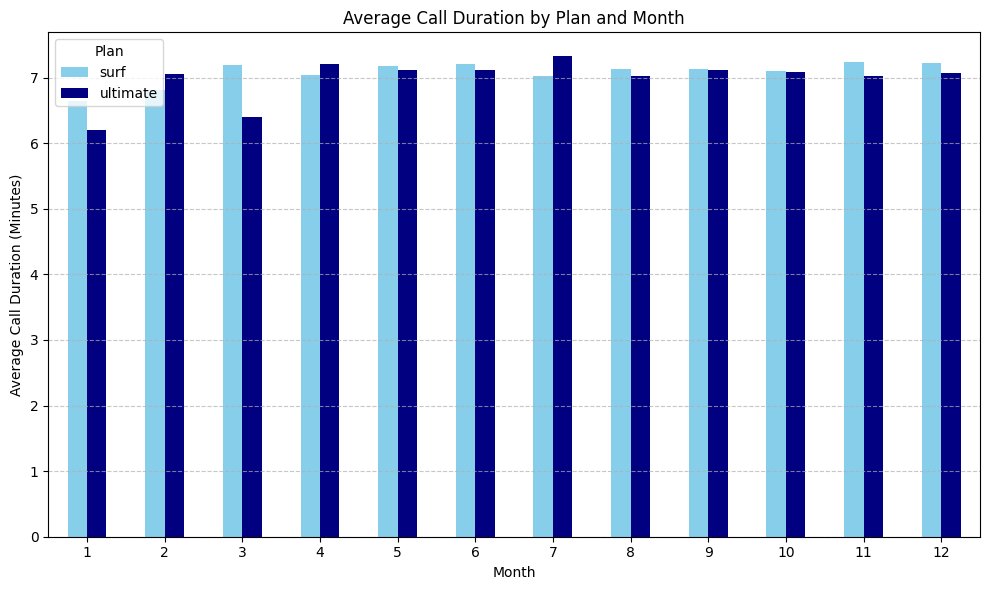

In [33]:
# Compare average duration of calls per each plan per each distinct month. Plot a bar plat to visualize it.


"""
Calculates the average call duration per plan per month 
and generates the code for a bar plot visualization.
"""
df_analysis = merged_data.copy()
    
# 1. Calculate Average Call Duration (per user-month)
# Filter out rows where calls_per_month is 0 to prevent division by zero
df_analysis = df_analysis[df_analysis['calls_per_month'] > 0]
    
    # Calculate the average duration of a single call (minutes / calls)
df_analysis['avg_call_duration'] = df_analysis['minutes_per_month'] / df_analysis['calls_per_month']
    
    # 2. Group and Aggregate: Calculate the mean of the average call duration by plan and month
plot_data = df_analysis.groupby(['plan', 'month'])['avg_call_duration'].mean().reset_index()
    
    # 3. Pivot the data for easier plotting and comparison (plans side-by-side)
pivot_data = plot_data.pivot(index='month', columns='plan', values='avg_call_duration')
    
print("\n--- Average Call Duration by Plan and Month (Minutes per call) ---")
print(pivot_data.to_string())

    # 4. Plotting Code
print("\n")
plt.figure(figsize=(10, 6))
    # Using the pivoted data to plot Surf and Ultimate side-by-side per month
pivot_data.plot(kind='bar', ax=plt.gca(), rot=0, color={'surf': 'skyblue', 'ultimate': 'navy'})
    
plt.title('Average Call Duration by Plan and Month')
plt.xlabel('Month')
plt.ylabel('Average Call Duration (Minutes)')
plt.legend(title='Plan')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
    # In a local Python environment, plt.show() would display the plot.
    # We include it here for completeness if run locally.
plt.show() 
    
    




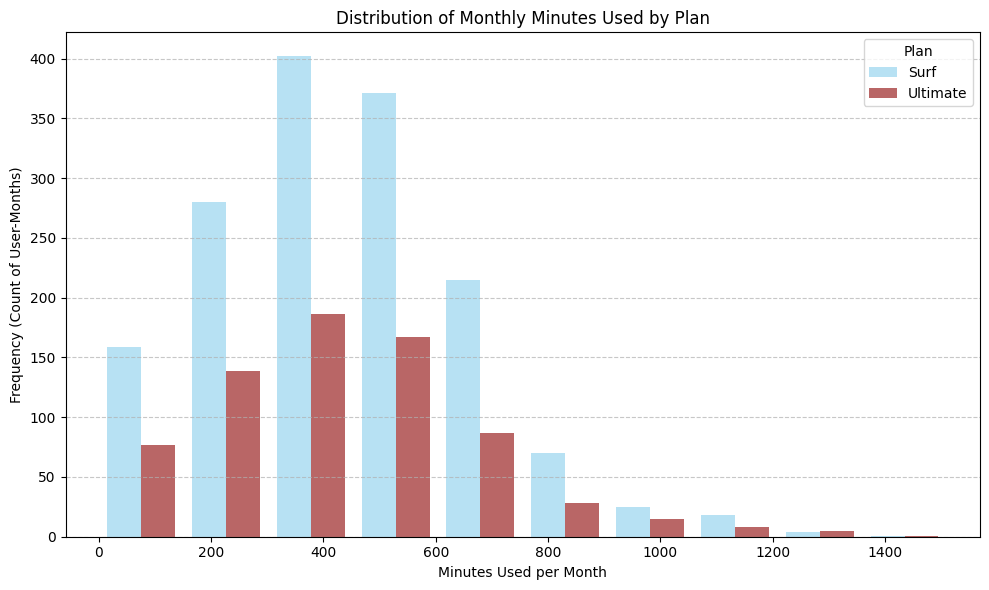

In [34]:
# Compare the number of minutes users of each plan require each month. Plot a histogram.
"""
Compares the distribution of monthly minutes used by users of the 'surf' and 'ultimate' plans 
and generates a histogram.
"""
    
# Separate minutes data by plan
surf_minutes = merged_data.query('plan == "surf"')['minutes_per_month'].dropna()
ultimate_minutes = merged_data.query('plan == "ultimate"')['minutes_per_month'].dropna()



# Plotting Code
print("\n")
plt.figure(figsize=(10, 6))
    
# Plotting the histograms with transparency (alpha) to allow comparison
plt.hist(
    [surf_minutes, ultimate_minutes], 
    bins=10, # Use a reasonable number of bins
    label=['Surf', 'Ultimate'], 
    color=['skyblue', 'darkred'],
    alpha=0.6,
    histtype='bar' 
    )
    
plt.title('Distribution of Monthly Minutes Used by Plan')
plt.xlabel('Minutes Used per Month')
plt.ylabel('Frequency (Count of User-Months)')
plt.legend(title='Plan')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
# In a local Python environment, plt.show() would display the plot.
# We include it here for completeness if run locally.
plt.show() 
    



In [35]:
# Calculate the mean and the variance of the monthly call duration
print("\n--- Distribution of Monthly Minutes Used per Plan ---")
    
print("Surf Plan - Minutes per Month Statistics:")
print(surf_minutes.describe())

print(f'variance:', surf_minutes.var())
print("\nUltimate Plan - Minutes per Month Statistics:")
print(ultimate_minutes.describe())

print(f'variance:', ultimate_minutes.var())



--- Distribution of Monthly Minutes Used per Plan ---
Surf Plan - Minutes per Month Statistics:
count    1545.000000
mean      436.519741
std       229.283805
min         0.000000
25%       279.000000
50%       430.000000
75%       579.000000
max      1510.000000
Name: minutes_per_month, dtype: float64
variance: 52571.06324345624

Ultimate Plan - Minutes per Month Statistics:
count     713.000000
mean      434.676017
std       237.852123
min         0.000000
25%       263.000000
50%       425.000000
75%       566.000000
max      1369.000000
Name: minutes_per_month, dtype: float64
variance: 56573.63224703341


C:\Users\tbbro\AppData\Local\Temp\ipykernel_1928\531473094.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


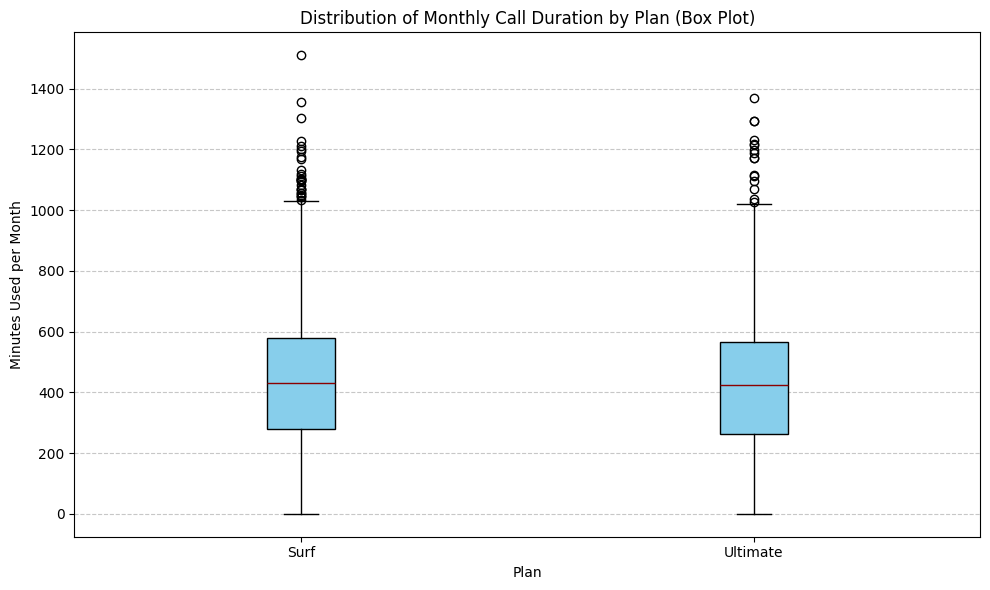

In [36]:
# Plot a boxplot to visualize the distribution of the monthly call duration

# Separate minutes data by plan
surf_minutes = merged_data.query('plan == "surf"')['minutes_per_month'].dropna()
ultimate_minutes = merged_data.query('plan == "ultimate"')['minutes_per_month'].dropna()


# Plotting Code
print("\n")
plt.figure(figsize=(10, 6))
    
# Plotting the box plots
plt.boxplot(
    [surf_minutes, ultimate_minutes],
    labels=['Surf', 'Ultimate'], 
    patch_artist=True, # Allows filling boxes with color
    boxprops=dict(facecolor='skyblue'), # Style props
    medianprops=dict(color='darkred')
    )
    
plt.title('Distribution of Monthly Call Duration by Plan (Box Plot)')
plt.xlabel('Plan')
plt.ylabel('Minutes Used per Month')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
# In a local Python environment, plt.show() would display the plot.
# We include it here for completeness if run locally.
plt.show() 
    

In [37]:
# It appears that the distribution of call durations of users in both plans are very  
# similar. The main difference I can see is that there are a lot more surf users than 
# ultimate users. 

### Messages

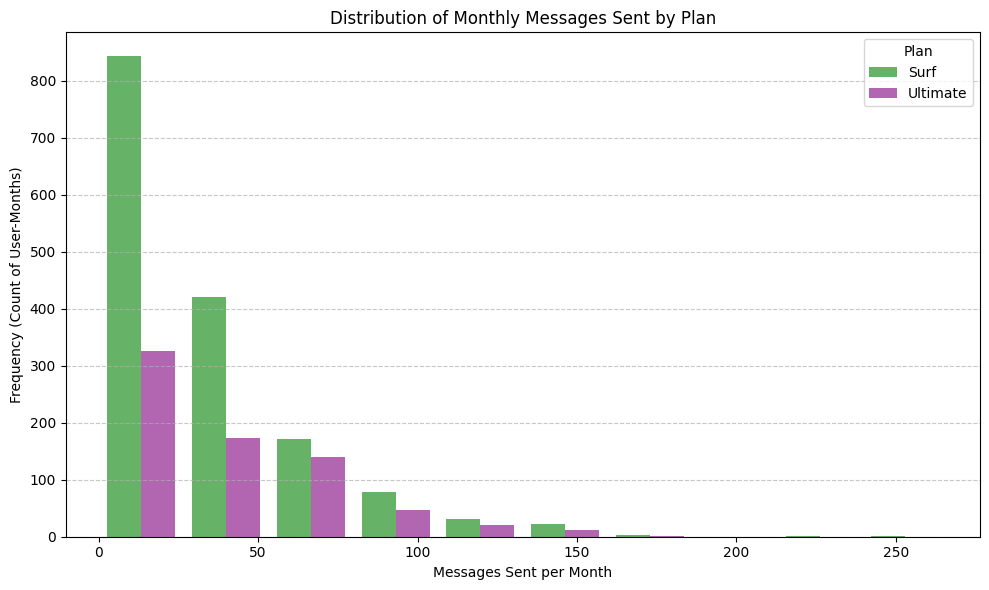

In [38]:
# Compare the number of messages users of each plan tend to send each month
surf_messages = merged_data.query('plan == "surf"')['messages_per_month'].fillna(0)
ultimate_messages = merged_data.query('plan == "ultimate"')['messages_per_month'].fillna(0)



# Plotting Code
print("\n")
plt.figure(figsize=(10, 6))
    
# Plotting the histograms with transparency (alpha) to allow comparison
plt.hist(
    [surf_messages, ultimate_messages], 
    bins=10, # Use a reasonable number of bins
    label=['Surf', 'Ultimate'], 
    color=['green', 'purple'],
    alpha=0.6,
    histtype='bar' 
    )
    
plt.title('Distribution of Monthly Messages Sent by Plan')
plt.xlabel('Messages Sent per Month')
plt.ylabel('Frequency (Count of User-Months)')
plt.legend(title='Plan')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
# In a local Python environment, plt.show() would display the plot.
plt.show() 
   

In [39]:

print("\n--- Distribution of Monthly Messages Sent per Plan ---")
    
print("Surf Plan - Messages per Month Statistics:")
print(surf_messages.describe())

print(f'Variance', surf_messages.var())

print("\nUltimate Plan - Messages per Month Statistics:")
print(ultimate_messages.describe())

print(f'Variance', ultimate_messages.var())


--- Distribution of Monthly Messages Sent per Plan ---
Surf Plan - Messages per Month Statistics:
count    1573.000000
mean       31.159568
std        33.566717
min         0.000000
25%         3.000000
50%        24.000000
75%        47.000000
max       266.000000
Name: messages_per_month, dtype: float64
Variance 1126.7245219504068

Ultimate Plan - Messages per Month Statistics:
count    720.000000
mean      37.551389
std       34.767179
min        0.000000
25%        7.000000
50%       30.000000
75%       61.000000
max      166.000000
Name: messages_per_month, dtype: float64
Variance 1208.7567435481378


C:\Users\tbbro\AppData\Local\Temp\ipykernel_1928\655465424.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


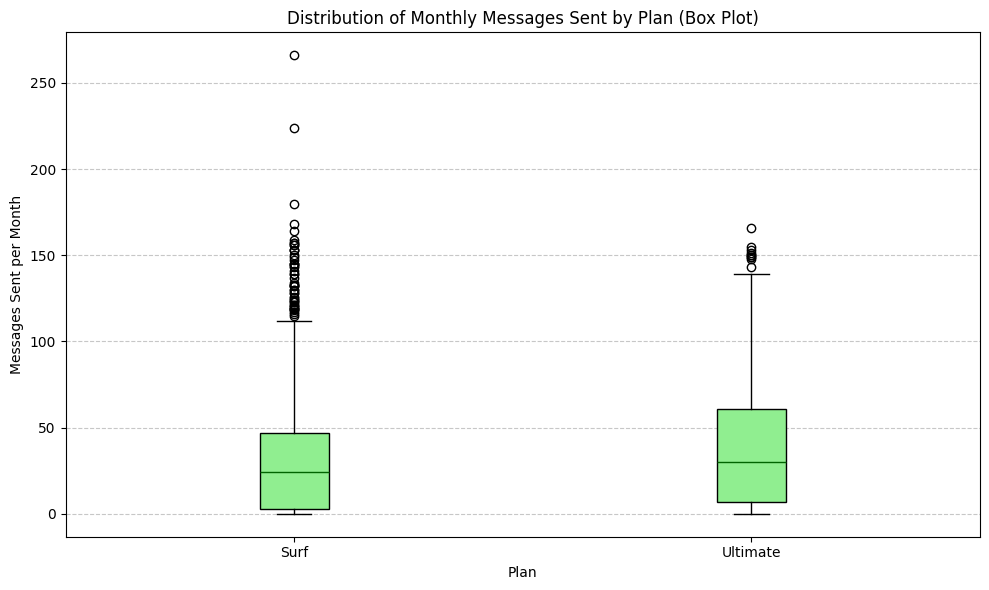

In [40]:
"""
Compares the distribution of monthly messages sent by users of the 'surf' and 'ultimate' plans 
and generates a box plot visualization.
"""
    


# Plotting Code
print("\n")
plt.figure(figsize=(10, 6))
    
# Plotting the box plots
plt.boxplot(
    [surf_messages, ultimate_messages],
    labels=['Surf', 'Ultimate'], 
    patch_artist=True, # Allows filling boxes with color
    boxprops=dict(facecolor='lightgreen'), # Style props
    medianprops=dict(color='darkgreen')
    )
    
plt.title('Distribution of Monthly Messages Sent by Plan (Box Plot)')
plt.xlabel('Plan')
plt.ylabel('Messages Sent per Month')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
# In a local Python environment, plt.show() would display the plot.
plt.show()

 We are now seeing some diferences in behavior between surf and ultimate users. Ultimate users send about 6 more messages per month per average users. Surf users still send way more messages in total due to there being more users. 

### Internet

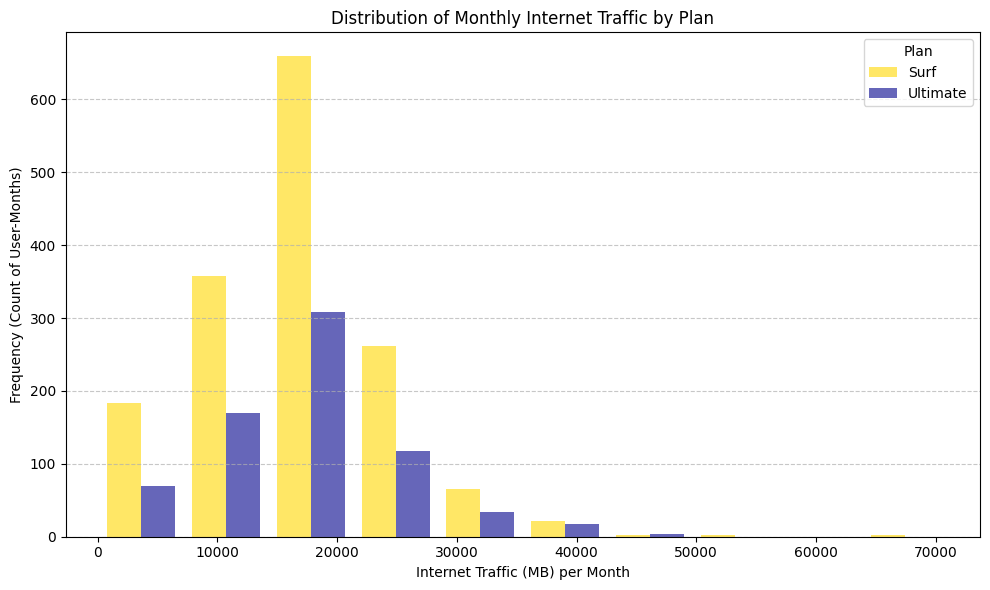

In [41]:
# Compare the amount of internet traffic consumed by users per plan
surf_data = merged_data.query('plan == "surf"')['mb_per_month'].dropna()
ultimate_data = merged_data.query('plan == "ultimate"')['mb_per_month'].dropna()



# Plotting Code
print("\n")
plt.figure(figsize=(10, 6))
    
# Plotting the histograms with transparency (alpha) to allow comparison
plt.hist(
    [surf_data, ultimate_data], 
    bins=10, # Use a reasonable number of bins
    label=['Surf', 'Ultimate'], 
    color=['gold', 'darkblue'],
    alpha=0.6,
    histtype='bar' 
    )
    
plt.title('Distribution of Monthly Internet Traffic by Plan')
plt.xlabel('Internet Traffic (MB) per Month')
plt.ylabel('Frequency (Count of User-Months)')
plt.legend(title='Plan')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
# In a local Python environment, plt.show() would display the plot.
plt.show()



In [42]:

print("\n--- Distribution of Monthly Internet Traffic (MB) per Plan ---")
    
print("Surf Plan - Internet Traffic (MB) per Month Statistics:")
print(surf_data.describe())
print(f'Variance', surf_data.var())
print("\nUltimate Plan - Internet Traffic (MB) per Month Statistics:")
print(ultimate_data.describe())
print(f'Variance', ultimate_data.var())



--- Distribution of Monthly Internet Traffic (MB) per Plan ---
Surf Plan - Internet Traffic (MB) per Month Statistics:
count     1558.000000
mean     16717.702137
std       7884.682983
min         92.310000
25%      12187.955000
50%      16923.830000
75%      21039.860000
max      70931.590000
Name: mb_per_month, dtype: float64
Variance 62168225.746928446

Ultimate Plan - Internet Traffic (MB) per Month Statistics:
count      719.000000
mean     17238.642253
std       7831.018323
min        233.170000
25%      12671.130000
50%      16863.450000
75%      21025.155000
max      46595.330000
Name: mb_per_month, dtype: float64
Variance 61324847.98095619


C:\Users\tbbro\AppData\Local\Temp\ipykernel_1928\711801695.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


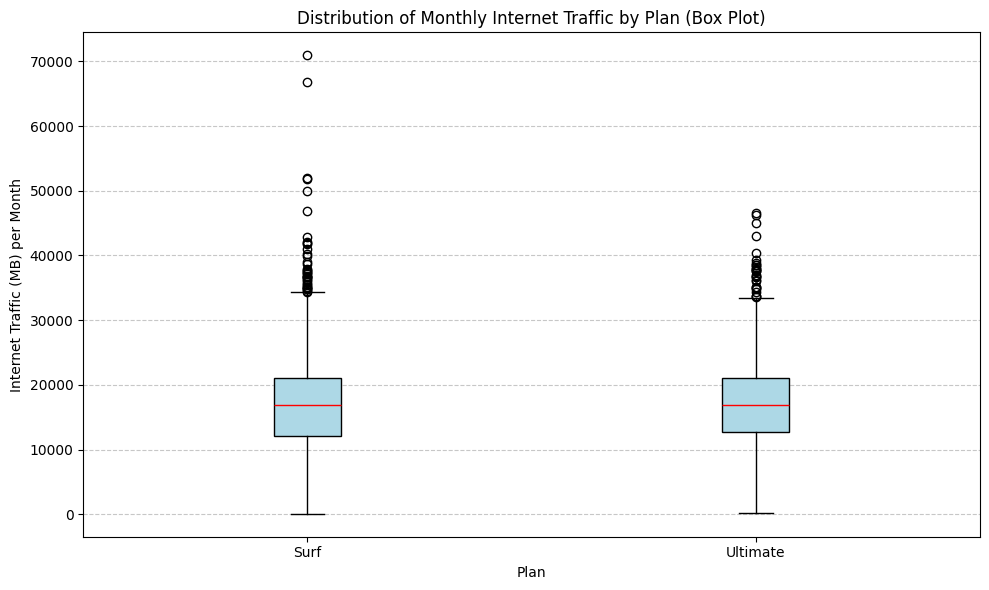

In [43]:
"""
Compares the distribution of monthly internet traffic (MB) used by users of the 'surf' 
and 'ultimate' plans and generates a box plot visualization.
"""
    
# Separate data traffic by plan, focusing on 'mb_per_month'
surf_data = merged_data.query('plan == "surf"')['mb_per_month'].dropna()
ultimate_data = merged_data.query('plan == "ultimate"')['mb_per_month'].dropna()


# Plotting Code
print("\n")
plt.figure(figsize=(10, 6))
    
# Plotting the box plots
plt.boxplot(
    [surf_data, ultimate_data],
    labels=['Surf', 'Ultimate'], 
    patch_artist=True, # Allows filling boxes with color
    boxprops=dict(facecolor='lightblue'), # Use a new color for distinction
    medianprops=dict(color='red')
    )
    
plt.title('Distribution of Monthly Internet Traffic by Plan (Box Plot)')
plt.xlabel('Plan')
plt.ylabel('Internet Traffic (MB) per Month')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
# In a local Python environment, plt.show() would display the plot.
plt.show() 



 Once again we are seeing very similar behavior between the users of either plan. Total usage by surf users continues to be significantly larger. There are also some very large outliers for surf users. 

## Revenue


--- Average Total Revenue by Plan and Month (USD) ---
plan        surf   ultimate
month                      
1      20.000000  70.000000
2      34.396667  70.000000
3      45.941304  74.666667
4      40.710600  73.000000
5      47.628182  70.724138
6      49.276289  71.638298
7      62.674050  71.898305
8      63.931173  72.859155
9      58.271495  72.034884
10     65.421224  72.311321
11     58.004276  71.708661
12     70.557044  73.291391




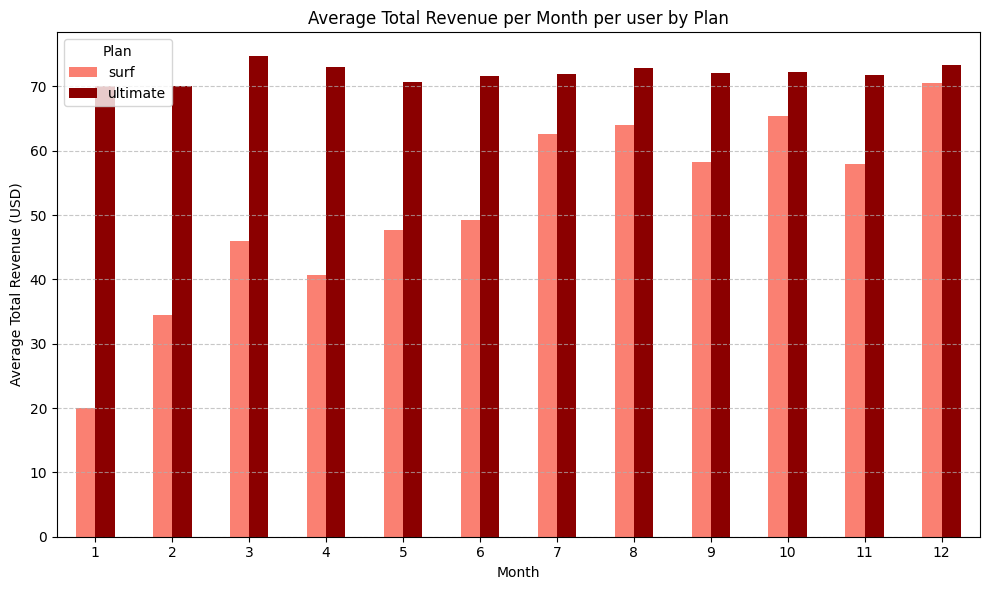

In [44]:

"""
1) Compares the average total revenue per month between the 'surf' and 'ultimate' plans.
"""
    
# Group by month and plan and calculate the mean of the total revenue
plot_data = final_report.groupby(['month', 'plan'])['total_revenue'].mean().reset_index()
    
# Pivot for easier plotting
pivot_data = plot_data.pivot(index='month', columns='plan', values='total_revenue')
    
print("\n--- Average Total Revenue by Plan and Month (USD) ---")
print(pivot_data.to_string())

# Plotting Code
print("\n")
plt.figure(figsize=(10, 6))
    
 # Plotting the bar chart
pivot_data.plot(kind='bar', ax=plt.gca(), rot=0, color={'surf': 'salmon', 'ultimate': 'darkred'})
    
plt.title('Average Total Revenue per Month per user by Plan')
plt.xlabel('Month')
plt.ylabel('Average Total Revenue (USD)')
plt.legend(title='Plan')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show() 



--- Distribution of Average Monthly Revenue per User (Histogram) ---




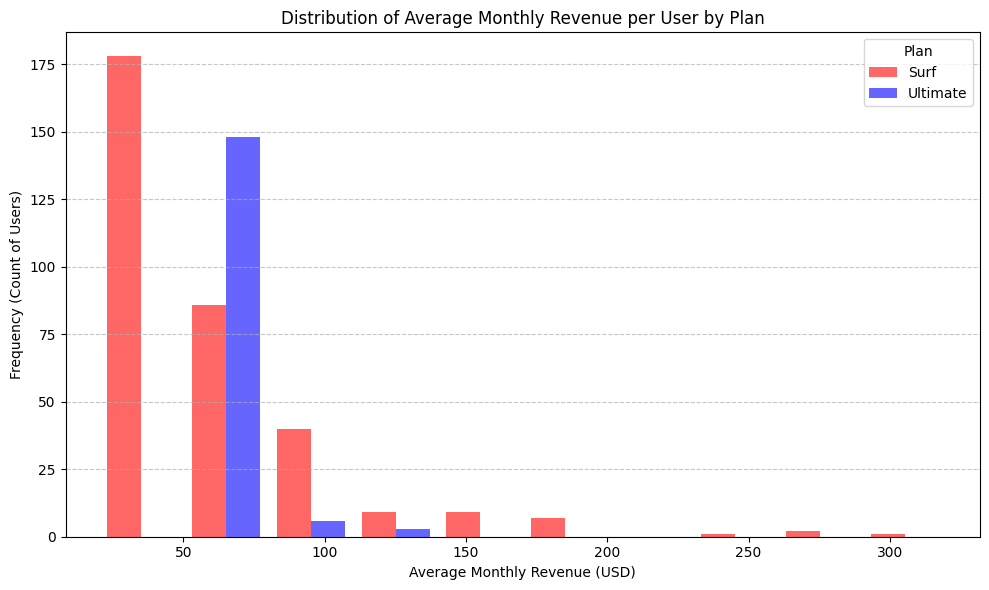

In [45]:
"""
2) Plots a histogram to visualize the distribution of average monthly revenue per user per plan.
"""
    # Calculate the average revenue per user (since final_report_df is monthly data)
user_monthly_avg_revenue = final_report.groupby(['user_id', 'plan'])['total_revenue'].mean().reset_index()
user_monthly_avg_revenue.rename(columns={'total_revenue': 'avg_monthly_revenue'}, inplace=True)
    
surf_revenue = user_monthly_avg_revenue.query('plan == "surf"')['avg_monthly_revenue'].dropna()
ultimate_revenue = user_monthly_avg_revenue.query('plan == "ultimate"')['avg_monthly_revenue'].dropna()

print("\n--- Distribution of Average Monthly Revenue per User (Histogram) ---")

    # Plotting Code
print("\n")
plt.figure(figsize=(10, 6))
    
    # Plotting the histograms
plt.hist(
    [surf_revenue, ultimate_revenue], 
    bins=10, 
    label=['Surf', 'Ultimate'], 
    color=['red', 'blue'],
    alpha=0.6,
    histtype='bar' 
    )
    
plt.title('Distribution of Average Monthly Revenue per User by Plan')
plt.xlabel('Average Monthly Revenue (USD)')
plt.ylabel('Frequency (Count of Users)')
plt.legend(title='Plan')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show() 



--- Distribution of Average Monthly Revenue per User (Box Plot) ---
Surf Plan - Average Monthly Revenue Statistics:
count    333.000000
mean      58.194344
std       43.565028
min       20.000000
25%       28.000000
50%       47.180000
75%       72.151111
max      320.185000
Name: avg_monthly_revenue, dtype: float64
Variance 1897.9116226477981

Ultimate Plan - Average Monthly Revenue Statistics:
count    157.000000
mean      71.823284
std        7.424766
min       70.000000
25%       70.000000
50%       70.000000
75%       70.000000
max      121.333333
Name: avg_monthly_revenue, dtype: float64
Variance 55.12714659851139




C:\Users\tbbro\AppData\Local\Temp\ipykernel_1928\1578429796.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


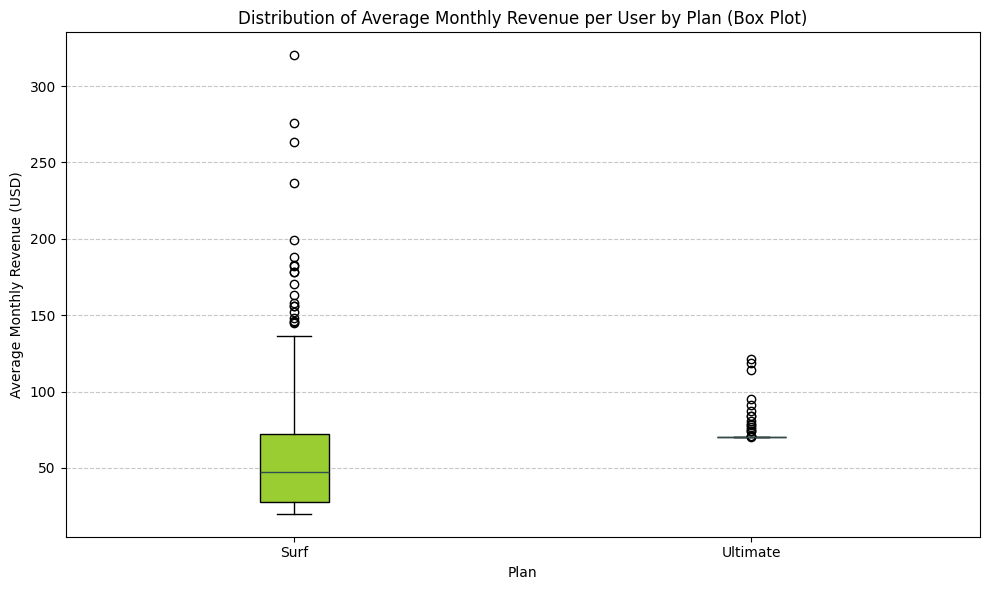

In [46]:
"""
3) Plots a box plot to visualize the distribution of average monthly revenue per user per plan.
"""
    # Calculate the average revenue per user (since final_report_df is monthly data)
user_monthly_avg_revenue = final_report.groupby(['user_id', 'plan'])['total_revenue'].mean().reset_index()
user_monthly_avg_revenue.rename(columns={'total_revenue': 'avg_monthly_revenue'}, inplace=True)
    
surf_revenue = user_monthly_avg_revenue.query('plan == "surf"')['avg_monthly_revenue'].dropna()
ultimate_revenue = user_monthly_avg_revenue.query('plan == "ultimate"')['avg_monthly_revenue'].dropna()

print("\n--- Distribution of Average Monthly Revenue per User (Box Plot) ---")
    
    # Print summary statistics
print("Surf Plan - Average Monthly Revenue Statistics:")
print(surf_revenue.describe())
print(f'Variance', surf_revenue.var())
print("\nUltimate Plan - Average Monthly Revenue Statistics:")
print(ultimate_revenue.describe())
print(f'Variance', ultimate_revenue.var())
    # Plotting Code
print("\n")
plt.figure(figsize=(10, 6))
    
    # Plotting the box plots
plt.boxplot(
    [surf_revenue, ultimate_revenue],
    labels=['Surf', 'Ultimate'], 
    patch_artist=True, # Allows filling boxes with color
    boxprops=dict(facecolor='yellowgreen'), # Style props
    medianprops=dict(color='darkslategray')
    )
    
plt.title('Distribution of Average Monthly Revenue per User by Plan (Box Plot)')
plt.xlabel('Plan')
plt.ylabel('Average Monthly Revenue (USD)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show() 


--- Total Revenue by Plan and Month (USD) ---
plan       surf  ultimate
month                    
1         40.00     280.0
2        309.57     490.0
3       1056.65     896.0
4       2035.53    1533.0
5       3667.37    2051.0
6       4779.80    3367.0
7       7583.56    4242.0
8      10356.85    5173.0
9      11304.67    6195.0
10     15504.83    7665.0
11     16415.21    9107.0
12     22437.14   11067.0




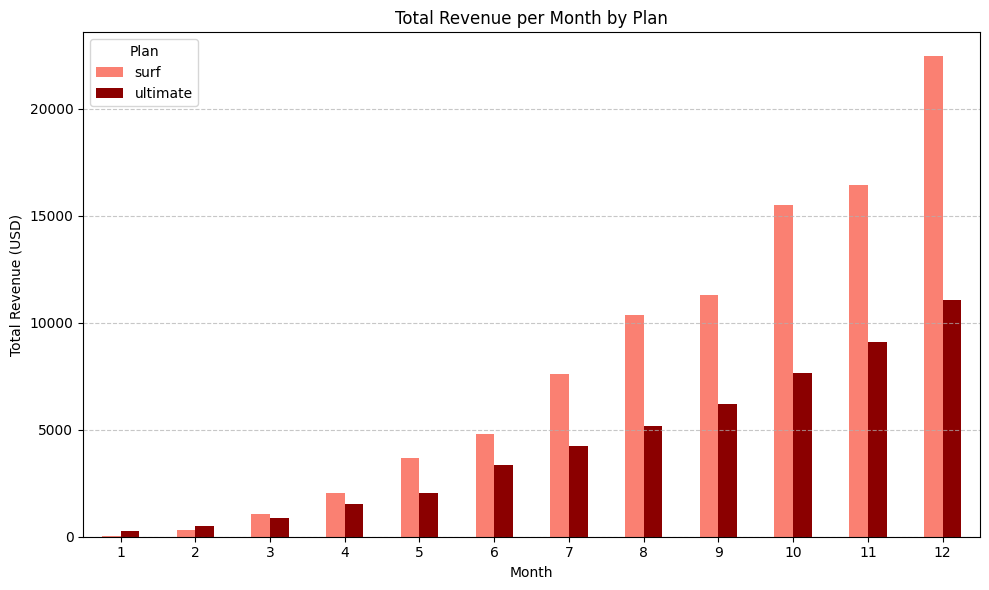

In [47]:

"""
1) Compares the TOTAL revenue per month between the 'surf' and 'ultimate' plans.
"""
    
    # Group by month and plan and calculate the SUM of the total revenue
plot_data = final_report.groupby(['month', 'plan'])['total_revenue'].sum().reset_index()
plot_data = plot_data.sort_values(by='month')
    
    # Pivot for easier plotting
pivot_data = plot_data.pivot(index='month', columns='plan', values='total_revenue')
    
print("\n--- Total Revenue by Plan and Month (USD) ---")
print(pivot_data.to_string())

    # Plotting Code
print("\n")
plt.figure(figsize=(10, 6))
    
    # Plotting the bar chart
pivot_data.plot(kind='bar', ax=plt.gca(), rot=0, color={'surf': 'salmon', 'ultimate': 'darkred'})
    
plt.title('Total Revenue per Month by Plan')
plt.xlabel('Month')
plt.ylabel('Total Revenue (USD)')
plt.legend(title='Plan')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show() 


In [48]:

total_annual_revenue_surf = final_report.query('plan == "surf"')['total_revenue'].sum()
print(f'The total annual revenue of surf users is: ${total_annual_revenue_surf:.2f}')

total_annual_revenue_ultimate = final_report.query('plan == "ultimate"')['total_revenue'].sum()
print(f'The total annual revenue of ultimate users is: ${total_annual_revenue_ultimate:.2f}')



The total annual revenue of surf users is: $95491.18
The total annual revenue of ultimate users is: $52066.00


 The data shows that ultimate users consistantly generate more revenue as individuals. While Surf users consistantly go over their limits and ultimate users typically just pay their base fee, ultimate users still pay more per month. Although ultimate users generate more revenue per user, it is important to note that surf users bring in nearly double the annual revinue compbined as a population. Slightly increasing the price of extra ussage for surf users could significantly increse profits. The last chart also demonstrates significant growth in revenue throught the year, probably do to more users joining, as time progressed. 

## Test statistical hypotheses

 H0: μ_surf = μ_ultimate; H1: μ_surf ≠ μ_ultimate
α = 0.05

In [49]:
# Test the hypotheses

# Calculate average revenue per user (one value per user)
user_avg_revenue = final_report.groupby(['user_id', 'plan'])['total_revenue'].mean().reset_index()

# Now separate by plan
surf_user_avg = user_avg_revenue[user_avg_revenue['plan'] == 'surf']['total_revenue']
ultimate_user_avg = user_avg_revenue[user_avg_revenue['plan'] == 'ultimate']['total_revenue']

# Check variance equality first
print("Surf variance:", surf_user_avg.var())
print("Ultimate variance:", ultimate_user_avg.var())

# Use Welch's t-test (doesn't assume equal variances)
t_stat, p_val = stats.ttest_ind(surf_user_avg, ultimate_user_avg, equal_var=False)
alpha = 0.05
print(f'surf revenue mean', surf_revenue.mean())
print(f'ultimate revenue mean', ultimate_revenue.mean())
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")
print(f"Alpha level: 0.05")
if (p_val < alpha):
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")



Surf variance: 1897.9116226477981
Ultimate variance: 55.12714659851139
surf revenue mean 58.19434440501106
ultimate revenue mean 71.82328379334749
T-statistic: -5.5407
P-value: 0.0000
Alpha level: 0.05
We reject the null hypothesis


We can see that we do have a statistcal argument for surf users paying less per month than ultimate users. 

H0: μ_NY-NJ = μ_other_regions; H1: μ_NY-NJ ≠ μ_other_regions
α = 0.05

In [50]:
# Test the hypotheses
final_report_with_city = final_report.merge(
    users[['user_id', 'city']], 
    on='user_id', 
    how='left')

# Calculate average monthly revenue per user by region
user_avg_by_region = final_report_with_city.groupby(['user_id', 'city'])['total_revenue'].mean().reset_index()

# Separate NY-NJ from other regions
ny_nj_users = user_avg_by_region[user_avg_by_region['city'].isin(['New York-Newark-Jersey City, NY-NJ-PA MSA'])]['total_revenue']
other_users = user_avg_by_region[~user_avg_by_region['city'].isin(['New York-Newark-Jersey City, NY-NJ-PA MSA'])]['total_revenue']

# Check variances
print("NY-NJ variance:", ny_nj_users.var())
print("Other regions variance:", other_users.var())

# Use Welch's t-test (handles unequal variances)
t_stat, p_val = stats.ttest_ind(ny_nj_users, other_users, equal_var=False)

alpha = 0.05

print(f'NY-NJ revenue mean', ny_nj_users.mean())
print(f'Else revenue mean', other_users.mean())
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")
print(f"Alpha level: 0.05")
if (p_val < alpha):
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

NY-NJ variance: 1072.0487248450024
Other regions variance: 1400.5684341454566
NY-NJ revenue mean 59.88967214641898
Else revenue mean 63.074667014250956
T-statistic: -0.7730
P-value: 0.4410
Alpha level: 0.05
We can't reject the null hypothesis


## General conclusion



My general conclusions for this project:

1) While the Ultimate plan brings in more revenue per user on average, the surf plan generates more revinue as a whole. t-test compairing means resulted in a p-value so small that is was still 0, 4 places after the decimal. Welchs t-test was used due to diferences in both population sizes and variance.
2) Both Surf and Ultimate users display similar behaviors in call duration and internet usage, the Ultimate users send more messages on average.
3) NY and NJ users on average do not bring in a significantly diferent revinue than other users (p-val = .4410, Alpha level: 0.05).
4) The total revenue from Surf users is growing significatly faster than the total revenu from Ultimate users.
5) Surf users consistantly go over their aloted service. 

I have an idea on how to increase revinue:

I think the curent payment plan is not structured well because surf users use a similar amount of service but pay significantly less. To fix this, increae the price of extra minutes/messages/data for surf users. This will increase the revinue while incentivising users to switch to the ultimate plan.

A final note: This studies the behaviors of customers over the year of 2018. At the begingin of the year surf customer revinue was far lower than that of ultimate customers but surf customer revinue was close ultimate customer revimue by the end of December. It would be interesting to see if this trend continues into 2019. 

Methods: 

Aggrigation: I was able to sum usage of each user/month with user_id's for each usage event. I was also able to combine all datafields excluding 'plans' by the user_id column. The plans datafield was later grouped in by the 'plan' column to create a comlete data frame of all relavent data to calculate revinue. 

To calculate revinue:
-All nan values were converted to zero
-mb/month were converted to GB and rounded up
-all call durations were rounded up to the nearestg minute 
-rows with churn dates were still included because cutomers will always come and go but they still afect revinue. 